- 이미 탈퇴한 회원과 계속 이용 중인 회원의 데이터를 이용, 지도학습의 분류 알고리즘 중 하나인 '의사결정 트리'로 탈퇴를 예측
- 의사결정 트리의 경우 간단한 알고리즘이지만 쉽게 원인 분석이 가능하므로 실무에서 자주 사용됨

### 데이터
- uselog_months.csv : 이용 이력을 연월/고객별로 집계한 데이터
- customer_join.csv : 이용 이력을 포함한 고객 데이터

### 테크닉 041 : 데이터를 읽어 들이고 이용 데이터를 수정하자

In [23]:
import pandas as pd

customer = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/5장/customer_join.csv')
uselog_months = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/5장/use_log_months.csv')

- 머신러닝을 위한 데이터 가공 필요
- 해당 달과 1개월 전의 이용 이력으로 데이터 생성 (6개월 분의 데이터를 이용할 경우, 5개월 이내에 가입한 회원의 탈퇴 예측이 불가능함)

In [24]:
year_months = list(uselog_months['연월'].unique())
uselog = pd.DataFrame()

for i in range(1, len(year_months)): # 해당 달과 1개월 전 데이터만 있으면 되므로 2018년 5월 데이터부터 반복
  tmp = uselog_months.loc[uselog_months['연월'] == year_months[i]]
  tmp.rename(columns = {'count' : 'count_0'}, inplace = True)

  tmp_before = uselog_months.loc[uselog_months['연월'] == year_months[i-1]]
  del tmp_before['연월']
  tmp_before.rename(columns = {'count' : 'count_1'}, inplace = True)
  
  tmp = pd.merge(tmp, tmp_before, on = 'customer_id', how = 'left')
  uselog = pd.concat([uselog, tmp], ignore_index = True)
uselog.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,연월,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


### 테크닉 042 : 탈퇴 전월의 탈퇴 고객 데이터를 작성하자

- end_date를 사용하지 않는 이유 : 탈퇴를 예측하는 목적은 탈퇴를 미연에 방지하는 것. 가령 9월 30일에 탈퇴하는 경우, 8월에 탈퇴 신청을 한 것이므로 9월 데이터를 사용해도 탈퇴 방지에 도움이 되지 않음
- 따라서 탈퇴 월을 8월로 설정하고, 그 1개월 전인 7월 데이터로 탈퇴 신청을 할 확률을 예측해야 방지가 가능

In [25]:
from dateutil.relativedelta import relativedelta

# 탈퇴한 회원 데이터를 추출, 저장
exit_customer = customer.loc[customer['is_deleted'] == 1]
exit_customer['exit_date'] = None
exit_customer['end_date'] = pd.to_datetime(exit_customer['end_date'])

for i in range(len(exit_customer)):
  exit_customer['exit_date'].iloc[i] = exit_customer['end_date'].iloc[i] - relativedelta(months = 1) # 1개월 전 데이터를 exit_date에 저장

exit_customer['연월'] = exit_customer['exit_date'].dt.strftime('%Y%m')
uselog['연월'] = uselog['연월'].astype(str)
exit_uselog = pd.merge(uselog, exit_customer, on = ['customer_id', '연월'], how = 'left')
print(len(uselog))
exit_uselog.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

33851


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 결합한 데이터는 탈퇴한 회원의 전월 이용 데이터이므로 결측치가 다수 존재
- 결측치가 없는 데이터만 남기고 나머지는 제거

In [26]:
exit_uselog = exit_uselog.dropna(subset = ['name']) # name 칼럼에 결측치가 있을 경우 삭제
print(len(exit_uselog))
print(len(exit_uselog['customer_id'].unique()))
exit_uselog.head()

1104
1104


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,1.0,종일,10500.0,일반,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30 00:00:00
57,201805,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,1.0,종일,10500.0,일반,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30 00:00:00
110,201805,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,1.0,종일,10500.0,일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30 00:00:00
128,201805,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,1.0,종일,10500.0,일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30 00:00:00
147,201805,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,1.0,야간,6000.0,일반,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30 00:00:00


### 테크닉 043 : 지속 회원의 데이터를 작성하자

- 지속 회원의 경우 탈퇴 월이 없기 때문에 아무 연월의 데이터를 작성해도 상관 없음
- 따라서 지속 회원 추출 후 uselog에 결합해주면 됨

In [27]:
# 지속 회원 추출 후 저장
conti_customer = customer.loc[customer['is_deleted'] == 0]
conti_uselog = pd.merge(uselog, conti_customer, on = ['customer_id'], how = 'left')
print(len(conti_uselog))

# name 칼럼에 결측치가 있을 경우 제거
conti_uselog = conti_uselog.dropna(subset = ['name'])
print(len(conti_uselog))

33851
27422


- 탈퇴 데이터 : 1104개, 지속 데이터 : 27422개로, 데이터의 불균형이 존재
- 이러한 경우, 샘플의 수를 조정하는 경우가 많음
- 지속 회원 데이터도 회원당 1개가 되게 언더샘플링 적용 (지속 회원 A씨의 데이터들 중 한 개의 월 데이터만 선택)

In [28]:
# 샘플링
conti_uselog = conti_uselog.sample(frac = 1).reset_index(drop = True)
# 중복 제거 : customer_id를 기준으로 중복 샘플링이 됐을 경우 중복 제거 → 한 회원 당 한 개의 데이터만 샘플링하게 됨
conti_uselog = conti_uselog.drop_duplicates(subset = 'customer_id')
print(len(conti_uselog))
conti_uselog.head()

2842


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201903,PL102815,9,9.0,XXXXXX,C01,M,2018-10-13,NaN,CA1,0.0,종일,10500.0,일반,8.166667,8.0,11.0,6.0,1.0,2019-04-30,6.0
1,201807,IK771427,2,5.0,XXXX,C02,M,2015-10-01,NaN,CA1,0.0,주간,7500.0,일반,3.750000,3.5,6.0,1.0,1.0,2019-04-30,42.0
2,201901,PL003692,8,9.0,XXXX,C03,M,2018-05-12,NaN,CA2,0.0,야간,6000.0,입회비반액할인,7.272727,7.0,11.0,4.0,1.0,2019-04-30,11.0
3,201807,PL103369,3,7.0,XXXXXX,C02,F,2017-05-01,NaN,CA1,0.0,주간,7500.0,일반,5.416667,5.0,10.0,3.0,1.0,2019-04-30,23.0
4,201812,TS493191,6,8.0,XX,C03,F,2017-11-01,NaN,CA1,0.0,야간,6000.0,일반,6.750000,6.0,9.0,4.0,1.0,2019-04-30,17.0


In [29]:
# 지속 회원 데이터와 탈퇴 회원 데이터를 세로로 결합
predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index = True)
print(len(predict_data))
predict_data.head()

3946


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201903,PL102815,9,9.0,XXXXXX,C01,M,2018-10-13,NaN,CA1,0.0,종일,10500.0,일반,8.166667,8.0,11.0,6.0,1.0,2019-04-30,6.0,NaN
1,201807,IK771427,2,5.0,XXXX,C02,M,2015-10-01,NaN,CA1,0.0,주간,7500.0,일반,3.750000,3.5,6.0,1.0,1.0,2019-04-30,42.0,NaN
2,201901,PL003692,8,9.0,XXXX,C03,M,2018-05-12,NaN,CA2,0.0,야간,6000.0,입회비반액할인,7.272727,7.0,11.0,4.0,1.0,2019-04-30,11.0,NaN
3,201807,PL103369,3,7.0,XXXXXX,C02,F,2017-05-01,NaN,CA1,0.0,주간,7500.0,일반,5.416667,5.0,10.0,3.0,1.0,2019-04-30,23.0,NaN
4,201812,TS493191,6,8.0,XX,C03,F,2017-11-01,NaN,CA1,0.0,야간,6000.0,일반,6.750000,6.0,9.0,4.0,1.0,2019-04-30,17.0,NaN


### 테크닉 044 : 예측할 달의 재적 기간을 작성하자

In [30]:
predict_data['period'] = 0
predict_data['now_date'] = pd.to_datetime(predict_data['연월'], format = '%Y%m')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])

for i in range(len(predict_data)):
  delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i])
  predict_data['period'][i] = int(delta.years*12 + delta.months) # 월 단위로 변환

predict_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,연월,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,period,now_date
0,201903,PL102815,9,9.0,XXXXXX,C01,M,2018-10-13,NaN,CA1,0.0,종일,10500.0,일반,8.166667,8.0,11.0,6.0,1.0,2019-04-30,6.0,NaN,4,2019-03-01
1,201807,IK771427,2,5.0,XXXX,C02,M,2015-10-01,NaN,CA1,0.0,주간,7500.0,일반,3.750000,3.5,6.0,1.0,1.0,2019-04-30,42.0,NaN,33,2018-07-01
2,201901,PL003692,8,9.0,XXXX,C03,M,2018-05-12,NaN,CA2,0.0,야간,6000.0,입회비반액할인,7.272727,7.0,11.0,4.0,1.0,2019-04-30,11.0,NaN,7,2019-01-01
3,201807,PL103369,3,7.0,XXXXXX,C02,F,2017-05-01,NaN,CA1,0.0,주간,7500.0,일반,5.416667,5.0,10.0,3.0,1.0,2019-04-30,23.0,NaN,14,2018-07-01
4,201812,TS493191,6,8.0,XX,C03,F,2017-11-01,NaN,CA1,0.0,야간,6000.0,일반,6.750000,6.0,9.0,4.0,1.0,2019-04-30,17.0,NaN,13,2018-12-01


### 테크닉 045 : 결측치를 제거하자

In [31]:
# 결측치 확인
predict_data.isna().sum()

연월                      0
customer_id             0
count_0                 0
count_1               262
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
period                  0
now_date                0
dtype: int64

- end_date, exit_date : 탈퇴 회원 데이터만 존재하며 지속 회원의 경우 존재하지 않음
- count_1 결측치만 제거

In [32]:
# count_1 칼럼 결측치 제거
predict_data = predict_data.dropna(subset = ['count_1'])
predict_data.isna().sum()

연월                      0
customer_id             0
count_0                 0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2632
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2632
period                  0
now_date                0
dtype: int64

### 테크닉 046 : 문자열 변수를 처리할 수 있게 가공하자

- 가입 캠페인 구분, 회원 구분, 성별과 같은 문자열 데이터 : 카테고리 변수
- 카테고리 변수를 활용하기 위해 플래그 생성 → '더미 변수' 생성
- 사용할 설명 변수 : count_1(1개월 전 이용 횟수), 카테고리 변수(campaign_name, class_name, gender), routine_flg(정기적 이용 여부 플래그), period(재적 기간)
- 목적 변수 : is_deleted(탈퇴 여부)
- 분류의 경우 탈퇴/유지와 같은 이산치를 목적 변수로 사용

In [33]:
# 설명 변수, 목적 변수 추출 후 저장
target_col = ['campaign_name', 'class_name', 'gender', 'count_1', 'routine_flg', 'period', 'is_deleted']
predict_data = predict_data[target_col]
predict_data.head()

,campaign_name,class_name,gender,count_1,routine_flg,period,is_deleted
0,일반,종일,M,9.0,1.0,4,0.0
1,일반,주간,M,5.0,1.0,33,0.0
2,입회비반액할인,야간,M,9.0,1.0,7,0.0
3,일반,주간,F,7.0,1.0,14,0.0
4,일반,야간,F,8.0,1.0,13,0.0


In [34]:
# 카테고리 변수 → 더미 변수
predict_data = pd.get_dummies(predict_data) # get_dummies : 일괄적으로 더미 변수 생성 가능
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_일반,campaign_name_입회비무료,campaign_name_입회비반액할인,class_name_야간,class_name_종일,class_name_주간,gender_F,gender_M
0,9.0,1.0,4,0.0,1,0,0,0,1,0,0,1
1,5.0,1.0,33,0.0,1,0,0,0,0,1,0,1
2,9.0,1.0,7,0.0,0,0,1,1,0,0,0,1
3,7.0,1.0,14,0.0,1,0,0,0,0,1,1,0
4,8.0,1.0,13,0.0,1,0,0,1,0,0,1,0


- 더미 변수 생성 시 주의할 점
- 가령 여성 칼럼의 값이 1일 경우 남성은 자동적으로 0이 되므로 일부러 남성 칼럼을 만들 필요가 없음
- 마찬가지로 캠페인 구분, 회원권 구분 역시 마찬가지

In [35]:
# campaign_name_일반, class_name_야간, gender_M 삭제
del predict_data['campaign_name_일반']
del predict_data['class_name_야간']
del predict_data['gender_M']

predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_입회비무료,campaign_name_입회비반액할인,class_name_종일,class_name_주간,gender_F
0,9.0,1.0,4,0.0,0,0,1,0,0
1,5.0,1.0,33,0.0,0,0,0,1,0
2,9.0,1.0,7,0.0,0,1,0,0,0
3,7.0,1.0,14,0.0,0,0,0,1,1
4,8.0,1.0,13,0.0,0,0,0,0,1


- 데이터 분석의 경우 데이터 가공이 80%

### 테크닉 047 : 의사결정 트리를 사용해서 탈퇴 예측 모델을 구축하자

In [36]:
# 필요한 라이브러리 임포트
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection

# 탈퇴 회원, 지속 회원으로 분할 후 저장
exit = predict_data.loc[predict_data['is_deleted'] == 1]
conti = predict_data.loc[predict_data['is_deleted'] == 0].sample(len(exit)) # exit의 갯수와 동일하게 맞춰주기 위해 샘플링

X = pd.concat([exit, conti], ignore_index = True) # exit와 conti 결합
y = X['is_deleted'] # is_deleted 값을 목적 변수로 사용하기 위해 y에 저장
del X['is_deleted']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y) # 학습용 데이터와 평가용 데이터로 분할

# 분류 모델 생성
model = DecisionTreeClassifier(random_state = 0)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(y_test_pred)

[0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.

In [37]:
# 정답과 비교하기 위해 실제 값 y_test와 함께 저장
results_test = pd.DataFrame({'y_test' : y_test, 'y_pred' : y_test_pred})
results_test.head()

,y_test,y_pred
1944,0.0,0.0
1232,0.0,0.0
844,1.0,1.0
820,1.0,0.0
1691,0.0,0.0


### 테크닉 048 : 예측 모델을 평가하고 모델을 튜닝해 보자

In [38]:
# 정답률 계산
correct = len(results_test.loc[results_test['y_test'] == results_test['y_pred']]) # y_test와 y_pred가 같은 경우 정답으로 치고 그 갯수를 correct에 저장
data_count = len(results_test)
score_test = correct / data_count # 정답/전체 갯수
print(score_test)

0.8916349809885932


- 정답률은 약 90% 정도
- 학습용 데이터로 예측한 정확도와 평가용 데이터로 예측한 정확도의 차이가 작은 것이 이상적

In [39]:
# 각각의 데이터를 이용했을 때의 정확도 계산(score 함수 이용)
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.8916349809885932
0.9771863117870723


- 학습용 데이터의 경우 98%로, 과적합 경향을 보임
- 해결 방법 : 데이터 늘리기, 변수 재검토, 파라미터 변경 등
- 이번에는 파라미터 변경 사용

In [40]:
X = pd.concat([exit, conti], ignore_index = True)
y = X['is_deleted']
del X['is_deleted']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

# 파라미터 max_depth를 5로 설정
model = DecisionTreeClassifier(random_state = 0, max_depth = 5)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.9201520912547528
0.9245880861850444


- 학습용 데이터의 정확도가 다소 낮아짐
- max_depth를 조정해줄 경우 모델이 단순해져 미지의 데이터에도 대응할 수 있는 모델이 만들어짐

### 테크닉 049 : 모델에 기여하는 변수를 확인하자

In [41]:
importance = pd.DataFrame({'feature_names' : X.columns, 'coefficient' : model.feature_importances_ })
importance

,feature_names,coefficient
0,count_1,0.371799
1,routine_flg,0.139222
2,period,0.488877
3,campaign_name_입회비무료,0.000000
4,campaign_name_입회비반액할인,0.000000
5,class_name_종일,0.000101
6,class_name_주간,0.000000
7,gender_F,0.000000


- 분류 모델의 경우 model.feature_importances_로 변수 중요도를 얻을 수 있음
- graphviz와 같은 라이브러리를 이용하면 비교적 간단하게 시각화 가능

### 테크닉 050 : 회원 탈퇴를 예측하자

In [42]:
# 임의의 데이터 생성
count_1 = 3
routine_flg = 1
period = 10
campaign_name = '입회비무료'
class_name = '종일'
gender = 'M'

In [43]:
# 데이터 가공

# 카테고리 변수 → 더미 변수로 변환
if campaign_name == '입회비반값할인':
  campaign_name_list = [1, 0]
elif campaign_name == '입회비무료':
  campaign_name_list = [0, 1]
elif campaign_name == '일반':
  campaign_name_list = [0, 0]

if class_name == '종일':
  class_name_list = [1, 0]
elif class_name == '주간':
  class_name_list = [0, 1]
elif class_name == '야간':
  class_name_list = [0, 0]

if gender == 'F':
  gender_list = [1]
elif gender == 'M':
  gender_list = [0]

input_data = [count_1, routine_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)

In [44]:
# 예측
print(model.predict([input_data])) # 1 또는 0으로 분류
print(model.predict_proba([input_data])) # 확률로 분류([0이 될 확률, 1이 될 확률])

[1.]
[[0. 1.]]


- 이 회원의 경우 탈퇴가 될 것으로 예측되며, 100% 탈퇴할 것으로 예측

### 별도) graphviz 이용, 의사결정트리 그래프 생성

In [46]:
! pip install graphviz # graphviz 설치

In [59]:
import graphviz # graphviz 임포트

In [60]:
feature_names = X.columns # 설명 변수

In [61]:
import numpy as np
target_name = np.array(['not deleted', 'deleted']) # 타겟 변수 : str 타입으로

In [62]:
from sklearn import tree
dt_dot_data = tree.export_graphviz(model, out_file = None, feature_names = feature_names, class_names = target_name, filled = True, rounded = True, special_characters = True)

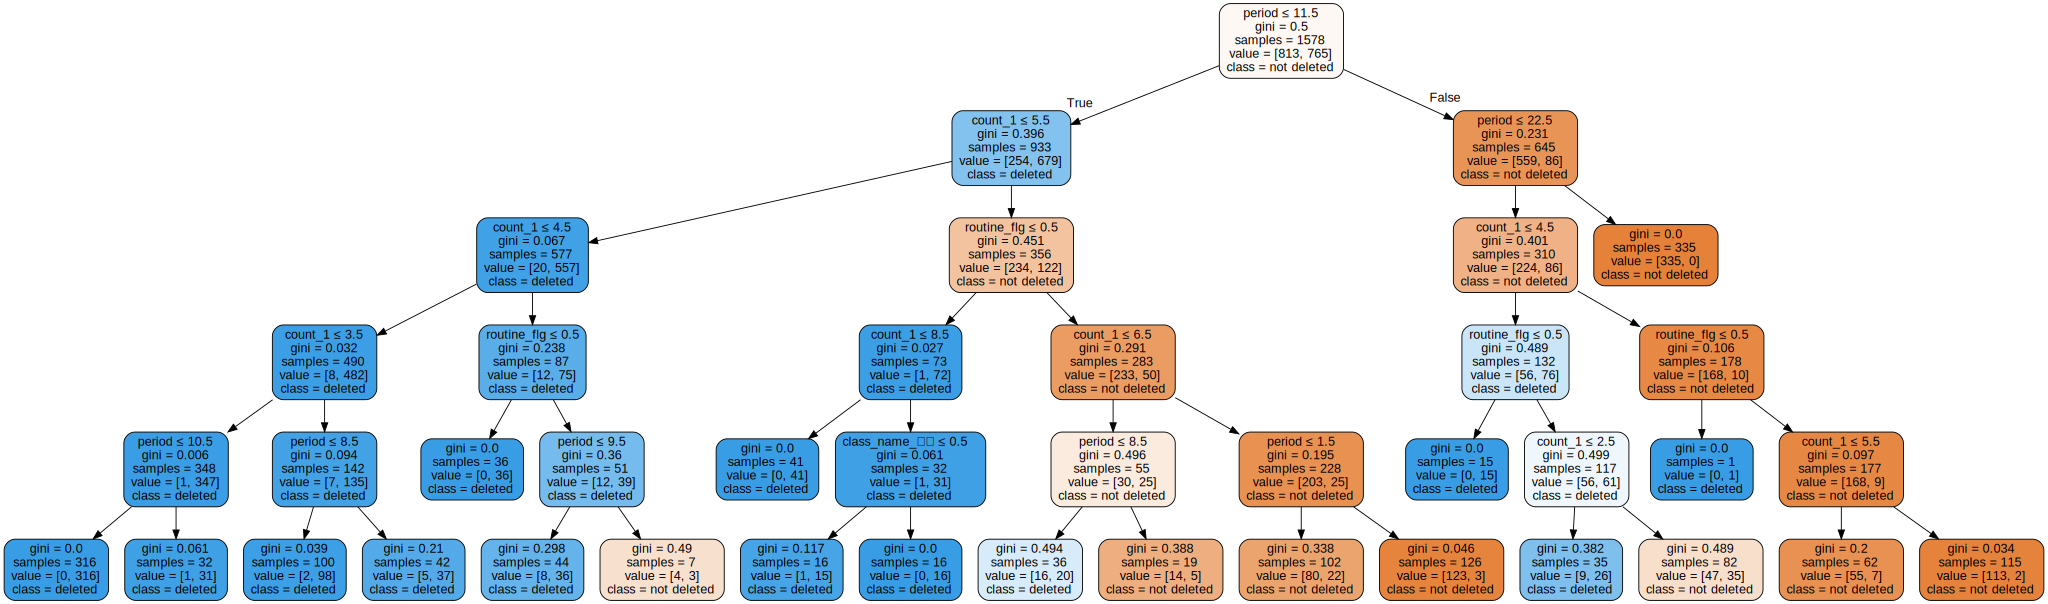

In [63]:
graph = graphviz.Source(dt_dot_data) # 그래프 생성
graph